# Machine Learning 
## Laboratory on Neural Networks with PyTorch

PyTorch is a machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, originally developed by Meta AI and now part of the Linux Foundation umbrella. It is one of many deep learning libraries out there, along with Keras and Tensorflow [1]. It is free and open-source software released under the modified BSD license. Many companies uses PyTorch to build their deep learning stack (e.g., Tesla Autopilot, Hugging's Face). 

[1] https://en.wikipedia.org/wiki/Comparison_of_deep_learning_software

## Google Colab

Google Colab is a  cloud service based on Jupyter  that enables to execute notebooks in the cloud, using resources from Google's datacenters.
Google even provides limited access to GPU, in order to accelerate tasks such as 
deep learning.

In [1]:
# Import the PyTorch libraries: torch torchvision and torchvision.transforms
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Instantiate the device we will use to train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Set the torch random seeds to ensure reproducibility
torch.manual_seed(0)

## CIFAR-10

The CIFAR-10 [1] dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In our case, we will use a greyscale version of these images to improve performances.

<img src="https://pytorch.org/tutorials/_images/cifar10.png"/>

[1] https://www.cs.toronto.edu/~kriz/cifar.html

In [4]:
# This class simply load the CIFAR10 torchvision dataset and it enables us to
# specify the classes we want to keep
import numpy as np

class CIFAR10Small(torchvision.datasets.CIFAR10):
    def __init__(self, *args, classes=3, **kwargs):
        super(CIFAR10Small, self).__init__(*args, **kwargs)

        requested_list = list(range(0,classes))

        labels = np.array(self.targets)
        keep = np.array(requested_list).reshape(1, -1)
        mask = (labels.reshape(-1, 1) == keep).any(axis=1)

        self.data = self.data[mask]
        self.targets = labels[mask].tolist()

In [5]:
# Load the torchvision dataset and create two dataloaders, one for training
# and one for testing.

batch_size = 128

transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale()])

trainset = CIFAR10Small(root='./data', train=True,
                      download=True, transform=transform)
testset = CIFAR10Small(root='./data', train=False,
                    download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


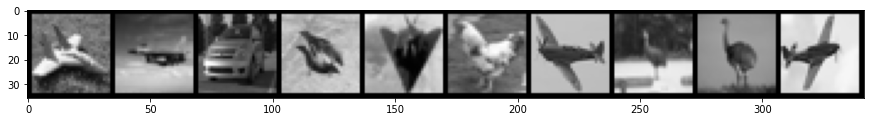

In [6]:
# Get some random images from the training set and plot them 
import matplotlib.pyplot as plt
import numpy as np

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(15, 20))
grid = torchvision.utils.make_grid(images[0:10], nrow=20)
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()

# Multi-layered Perceptron (MLP)

<img src="https://www.researchgate.net/publication/291339457/figure/fig1/AS:334187497312256@1456687916125/Typical-structure-of-a-feed-forward-multilayer-neural-network.png" width=500>

Image taken from [here](https://www.researchgate.net/publication/291339457_Artificial_Neural_Networks_as_Decision_Support_Tools_in_Cytopathology_Past_Present_and_Future/figures?lo=1)

In [7]:
# Implement an MLP module which we will use classify the CIFAR10 dataset
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):

  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(32*32, 32*16)
    self.fc2 = nn.Linear(32*16, 32*8)
    self.fc3 = nn.Linear(32*8, 3)

  def forward(self, x):
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [8]:
# Istantiate an MLP object and load it into the GPU 
mlp = MLP()
mlp.to(device)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=3, bias=True)
)

In [9]:
# Print how many parameters has my model
from torchsummary import summary
summary(mlp, input_size=(1, 32*32), batch_size=10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [10, 1024]               0
            Linear-2                  [10, 512]         524,800
            Linear-3                  [10, 256]         131,328
            Linear-4                    [10, 3]             771
Total params: 656,899
Trainable params: 656,899
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.14
Params size (MB): 2.51
Estimated Total Size (MB): 2.68
----------------------------------------------------------------


# Training a Deep Learnig model

## Loss function

After we define the model, we want to train it using the CIFAR10 data, using gradient descent. To do so, we first need to define a **loss function**. For this task we are going to use the **cross-entropy loss**. This loss function is suitable for multiclass classification problems. Given the ground truth labels $\mathbf{y} = \{y_i\}_{i=1}^{C}$ and the predicted probabilities $\hat{\mathbf{y}} = \{ \hat{y}_i \}_{i=1}^{C}$, our loss function $\mathcal{L}(\hat{\mathbf{y}}, \mathbf{y})$ becomes:

\begin{equation}
    \mathcal{L}(\hat{\mathbf{y}}, \mathbf{y}) = - \sum_i y_i \log(\hat{y}_i)
\end{equation}

PyTorch provides us with the `torch.nn.CrossEntropyLoss` class which implements the loss. It works also with unnormalized probabilities.

## Optimizer

We then need an optimizer for the gradient descent procedure. In our case, we will use **Adam (Adaptive Moment Estimation) (Kingma and Ba, 2014)**, an improved version of *RMSProp* which uses the gradients and the second moment of the gradients. Different optimizers have different properties and some of them are better than others on average (although this might not be true for all the datasets). See the image below for an example.

<img src="http://2.bp.blogspot.com/-q6l20Vs4P_w/VPmIC7sEhnI/AAAAAAAACC4/g3UOUX2r_yA/s400/s25RsOr%2B-%2BImgur.gif" />

[1] Kingma, Diederik; Ba, Jimmy (2014). "Adam: A Method for Stochastic Optimization". arXiv:1412.6980 [cs.LG].

Image taken from http://www.denizyuret.com/2015/03/alec-radfords-animations-for.html

### Intuition behind ADAM (Stochastic Optimization)

Let's look at how SGD and Adam implement the evaluation of the gradient.

**SGD** pseudo-code:

<img src="https://miro.medium.com/v2/resize:fit:1200/1*VJtZA2FtLi_CKPBtqIoeQg.png" width=500 />



**ADAM** pseudo-code:

<img src="https://www.baeldung.com/wp-content/ql-cache/quicklatex.com-f2b6aeb55a3bff6bb1905679e83e5f3f_l3.svg" width=500 />

In [10]:
# Instantiate an optimizer (Adam) and a suitable loss function (CrossEntropyLoss)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Our training framework is an iterative procedure that starts by sampling a batch of examples from the training set, coupled with their labels. 
The data is fed to the model, whose predictions are matched with the
true labels via a loss function. Then the gradient of the loss with
respect to the parameters of the model is computed, and used to 
update the parameters (following the directions in which it decreases).

We usually fed multiple times the entire dataset during training. Each complete pass of the dataset is called *epoch*.

In [11]:
# Implement a training loop function over the dataset.
# The steps are forward + backward + optimize

def train_model(model, dataloader, criterion, optimizer, epochs=10):

  for epoch in range(epochs):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):

      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      if (i+1)%100 == 0:
        print(f"Epoch {epoch+1} - Iteration {i+1}: Loss {running_loss/100}")
        running_loss = 0.0

In [12]:
# Train the model using the function defined above
train_model(mlp, trainloader, criterion, optimizer, 10)

Epoch 1 - Iteration 100: Loss 0.9516300421953201
Epoch 2 - Iteration 100: Loss 0.8495200461149216
Epoch 3 - Iteration 100: Loss 0.8023826169967652
Epoch 4 - Iteration 100: Loss 0.770165274143219
Epoch 5 - Iteration 100: Loss 0.7441767591238022
Epoch 6 - Iteration 100: Loss 0.7287499088048935
Epoch 7 - Iteration 100: Loss 0.6881779885292053
Epoch 8 - Iteration 100: Loss 0.6714271837472916
Epoch 9 - Iteration 100: Loss 0.6612476789951325
Epoch 10 - Iteration 100: Loss 0.644560312628746


In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import classification_report

# Write a function to evaluate the model
def evaluate_model(net, dataloader):

  # Evaluate the trained model on the data of the test set
  correct = 0
  total = 0

  predictions = []
  ground_truth = []
  predictions_probabilities = []

  # We do not need to compute the gradients since we are not training the model
  with torch.no_grad():
      for data in testloader:
          
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)

          outputs = net(images)

          # We get the class with the higher probability
          _, predicted = torch.max(outputs.data, 1)

          # Save informations we will need
          predictions_probabilities += outputs.tolist()
          ground_truth += labels.tolist()
          predictions += predicted.tolist()

  print(f'Accuracy: {accuracy_score(ground_truth, predictions):.2f} %')
  print(f'Top-k Accuracy (k=2): {top_k_accuracy_score(ground_truth, predictions_probabilities):.2f} %')
  print()
  print(classification_report(ground_truth, predictions))

  return predictions, ground_truth, predictions_probabilities

In [14]:
predictions, ground_truth, predictions_probabilities = evaluate_model(mlp, testloader)

Accuracy: 0.69 %
Top-k Accuracy (k=2): 0.93 %

              precision    recall  f1-score   support

           0       0.75      0.46      0.57      1000
           1       0.80      0.78      0.79      1000
           2       0.59      0.84      0.70      1000

    accuracy                           0.69      3000
   macro avg       0.72      0.69      0.69      3000
weighted avg       0.72      0.69      0.69      3000



# Convolutional Neural Network (CNN)

"In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of artificial neural network (ANN), most commonly applied to analyze visual imagery" (taken from, Wikipedia).They employ a series of convolution kernels which transform the input, and they learn to find patterns of increasing complexity in an hierarchical manner.

There are many of these architectures (e.g, AlexNet, ResNet, VGG), but we are going to see one of the first ones which is considered as the step-stone for the computer vision field, **LeNet-5 (Lecun et al., 1998)**. 

The original formulation is composed by two convolution layers which use subsampling to reduce the size of the input. The convolution part can be seen as a **feature extractor**. Then, it uses a standard MLP to perform classification.



[1] Lecun, Y.; Bottou, L.; Bengio, Y.; Haffner, P. (1998). "Gradient-based learning applied to document recognition". Proceedings of the IEEE. 86 (11): 2278–2324. doi:10.1109/5.726791.

## Convolutional Layer

See [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) for the PyTorch implementation.

A convolutional layer takes as input a matrix and divides it into smaller "patches". The size of the patch is called **kernel size**. The "speed" we move the patch is called **stride**. It outputs a number of features (channels) for each patch, exploiting locality and parameter sharing between "close" pixels. The resulting tensor will be similar to the one in the following picture.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png" width="400px"/>

The operation of applying a convolution is shown below. In the following example, we have a **kernel size = 3 x 3** and **stride = 1**.

<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif" width="250px" />

Applying a convolution reduces the size of the input image. This effect is not always desirable, since we might lose important information. Therefore, we add some "padding" to the image (usually zeroes), such to maintain the original dimensions.

<img src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/same_padding_no_strides.gif" width="400px" />

## Pooling layer

See [torch.nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) for the PyTorch implementation.

The Pooling layer is a filter that is used to reduce the number of the input dimensions between two convolutional layers. It is useful for dimensionality reduction and it avoids overfitting. It can be seen as a form of regularization.

A common example is the *Max pooling Layer*, in which we partition the input image into a set of rectangles and, for each such sub-region, we output the maximum.

<img src="http://www.wildml.com/wp-content/uploads/2015/11/Screen-Shot-2015-11-05-at-2.18.38-PM.png" width="400px" />

## LeNet-5

<img src="https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/lenet-5.png"/>



In [15]:
# Implement LeNet-5 based on the picture above. Bear in mind that here we have
# onluy 3 class to predict, so the last layer must be scalled accordingly.
import torch.nn as nn
import torch.nn.functional as F


class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 3)

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.flatten(x) # flatten all dimensions except batch
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [16]:
# Instantiate the LeNet object and move it to the GPU
lenet = LeNet5()
lenet.to(device)

LeNet5(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=300, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=3, bias=True)
)

In [17]:
# Print how many parameters has the LeNet5 model and compare it with the MLP
summary(lenet, input_size=(1, 32, 32), batch_size=10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [10, 6, 28, 28]             156
         MaxPool2d-2            [10, 6, 14, 14]               0
            Conv2d-3           [10, 12, 10, 10]           1,812
         MaxPool2d-4             [10, 12, 5, 5]               0
           Flatten-5                  [10, 300]               0
            Linear-6                  [10, 120]          36,120
            Linear-7                   [10, 60]           7,260
            Linear-8                    [10, 3]             183
Total params: 45,531
Trainable params: 45,531
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.60
Params size (MB): 0.17
Estimated Total Size (MB): 0.81
----------------------------------------------------------------


In [18]:
# Instantiate the loss criterion and the optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)

In [20]:
# Train the LeNet5 with 10 epochs
train_model(lenet, trainloader, criterion, optimizer, 10)

Epoch 1 - Iteration 100: Loss 0.6199147483706474
Epoch 2 - Iteration 100: Loss 0.572691272199154
Epoch 3 - Iteration 100: Loss 0.5512168422341347
Epoch 4 - Iteration 100: Loss 0.5257362231612206
Epoch 5 - Iteration 100: Loss 0.5000618922710419
Epoch 6 - Iteration 100: Loss 0.48992719382047656
Epoch 7 - Iteration 100: Loss 0.4614032629132271
Epoch 8 - Iteration 100: Loss 0.46538526952266696
Epoch 9 - Iteration 100: Loss 0.451975162923336
Epoch 10 - Iteration 100: Loss 0.43639777809381486


In [21]:
# Evaluate the trained LeNet5 model on the test set
predictions, ground_truth, predictions_probabilities = evaluate_model(lenet, testloader)

Accuracy: 0.80 %
Top-k Accuracy (k=2): 0.97 %

              precision    recall  f1-score   support

           0       0.72      0.83      0.77      1000
           1       0.88      0.84      0.86      1000
           2       0.81      0.73      0.77      1000

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000



## Extras: Avoid overfitting with Neural Networks


### Dropout

Dropout [1] is a regularization technique for neural networks. We set a probability of dropping random nodes from the networks at each gradient descent step. This way, the network is going to learn a more robust model, not relying too much on a single node for a prediction. In some sense, using dropout we are "sampling" a lot of different networks and learning them, and finally we are left with the "average" network, which is less susceptible to outliers.

<img src="https://pgaleone.eu/images/dropout/dropout.jpeg" width="400px" />

### Batch Normalization

It is a regularization technique [2] which we can use to make neural networks training to be faster and more stable. It avoids the problem of **internal covariate shift**, since different weights induce different input distributions in later layers. Moreover, the network becomes more robust to different initialization schemes and learning rates. 


[1] Hinton et al. (2012). "Improving neural networks by preventing co-adaptation of feature detectors". arXiv:1207.0580
[2] Ioffe and Szegedy (2015). "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift". arXiv:1502.03167.





In [22]:
# Extend the LeNet model to perform dropout and bacth normalization
class LeNet5Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 3)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
      x = self.pool(F.relu(self.bn1(self.conv1(x))))
      x = self.pool(F.relu(self.bn2(self.conv2(x))))
      x = self.flatten(x) # flatten all dimensions except batch
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.fc3(x)
      return x

In [23]:
lenet_dropout = LeNet5Dropout()
lenet_dropout.to(device)

optimizer = torch.optim.Adam(lenet_dropout.parameters(), lr=0.001)
train_model(lenet_dropout, trainloader, criterion, optimizer, 10)

Epoch 1 - Iteration 100: Loss 0.7896891009807586
Epoch 2 - Iteration 100: Loss 0.5851332890987396
Epoch 3 - Iteration 100: Loss 0.5262641188502312
Epoch 4 - Iteration 100: Loss 0.48459667384624483
Epoch 5 - Iteration 100: Loss 0.45394596219062805
Epoch 6 - Iteration 100: Loss 0.430021390914917
Epoch 7 - Iteration 100: Loss 0.41975923091173173
Epoch 8 - Iteration 100: Loss 0.3971377244591713
Epoch 9 - Iteration 100: Loss 0.3864807578921318
Epoch 10 - Iteration 100: Loss 0.36859546303749086


In [24]:
_ = evaluate_model(lenet_dropout, testloader)

Accuracy: 0.84 %
Top-k Accuracy (k=2): 0.97 %

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1000
           1       0.88      0.92      0.90      1000
           2       0.80      0.83      0.82      1000

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



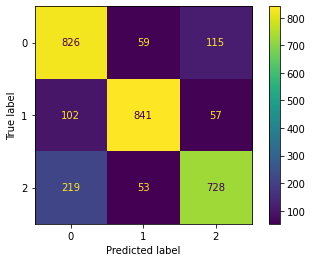

In [25]:
# Plot the confusion matrix using sklearn.metrics.ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

fig = ConfusionMatrixDisplay.from_predictions(ground_truth, predictions,
                                             display_labels=['airplane', 'automobile', 'car'])
plt.show()